# Data Stack Preparation

This tutorial will walk you through the workflow of the [VegMapper](https://github.com/NaiaraSPinto/VegMapper) repo. At the end of this tutorial, you will create multi-band geotiffs that can be used for the identification and classification of specific agroforestry systems, such as palm-oil plantations.

NOTE: This notebook should be launched from an AWS EC2 instance with the conda evironment activated. A tutorial for setting up a jupyter server on an EC2 instance can be found [here](https://github.com/NaiaraSPinto/VegMapper/blob/devel-stacks/prereq.md). Instructions for setting up the conda environment can be found in [section 2](#2.-Set-up-vegmapper-conda-environment) of this notebook.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import vegmapper

## User inputs

In [2]:
# Area of interest
aoi_name = 'malaysia'
aoi_boundary = 's3://servir-public/tests/malaysia/peninsular_malaysia.geojson'

# Project directory on S3
proj_dir = 's3://servir-public/tests/malaysia'

# Resolution
res = 30

# Time of interest
year = 2020
start_date = '2020-01-01'
end_date = '2020-02-01'

## Prepare UTM tiles covering Area of Interest (AOI) ##

To create the stacks, a universal tiling system is required to ensure all data sources are aligned to the same grid. In the following section, we will generate a geoJSON file that contains the tiles to be used by all of the data processing scripts. This is accomplished via the `vegmapper.prep_tiles`.

#### Usage ####

```
vegmapper.prep_tiles(aoi_name, aoi_boundary, tile_size)
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`aoi_name`||Used to name the output geoJSON. The generated tiles can be found at `aoi_name`_tiles.geojson.||Yes||None|
|`aoi_boundary`||shp/geoJSON file that contains the boundaries of our area of interest. geoJSON files for many subnational administrative boundaries can be found [here](https://data.humdata.org/dataset?ext_subnational=1&res_format=GeoJSON&vocab_Topics=administrative%20divisions&q=&sort=if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc&ext_page_size=25).||Yes||None|
|`tile_size`||The desired tile size, in meters.||Yes||None|

In [3]:
# Select desired tile size in meters
tile_size = 150000

Generate the UTM tiles by running the cell below:

In [4]:
aoi_tiles = vegmapper.prep_tiles(aoi_name, aoi_boundary, tile_size, centered=True)

Tiles for malaysia is saved to: s3://servir-public/tests/malaysia/malaysia_tiles.geojson
16 out of 20 tiles intersecting malaysia


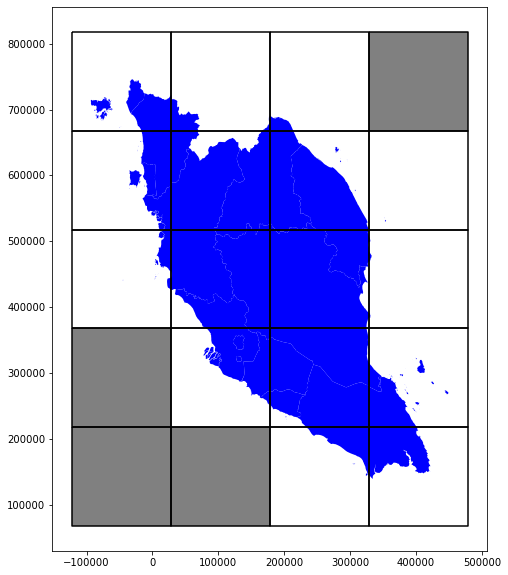

In [5]:
# Read in tiles and boundary
gdf_tiles = gpd.read_file(aoi_tiles)
gdf_boundary = gpd.read_file(aoi_boundary)
gdf_boundary_utm = gdf_boundary.to_crs(gdf_tiles.crs)

# Plot tiles
ax = gdf_tiles.boundary.plot(figsize=(10, 10), color='black')
# Plot boundary
gdf_boundary_utm.plot(ax=ax, color='blue')
# Plot tiles not intersecting AOI in gray
if (gdf_tiles['mask'] == 0).any():
    ax = gdf_tiles[gdf_tiles['mask'] == 0].plot(ax=ax, color='gray')

The tiles not intersecting AOI are shown in gray color. The final data stacks will not be generated for these tiles.

## Search Sentinel-1 Granules ##

The first piece of the data stack is Sentinel-1 tiles. In the following section, we search for granules within our AOI, process them using the ASF HyP3 API, and calculate statistics for the granules.

**Explain granules/scenes, path frames**
granules/scenes: space and time
path-frames: space only

In [6]:
start = '2021-01-01'
end = '2021-02-01'
gdf_granules, s1_metadata = vegmapper.s1.search_granules(aoi_name, aoi_boundary, start, end, skim=True, flightDirection=None)

35 granules found for ASCENDING orbits.
17 granules found for DESCENDING orbits.

The granules of ASCENDING orbits will be used.

Metadata of S1 granules saved to: s3://servir-public/tests/malaysia/malaysia_s1_granules_20210101-20210201.geojson

2 frames are skimmed from the search results

Metadata of S1 skimmed granules saved to: s3://servir-public/tests/malaysia/malaysia_s1_skimmed_granules_20210101-20210201.geojson
Metadata of S1 frames saved to: s3://servir-public/tests/malaysia/malaysia_s1_frames_20210101-20210201.geojson


In [7]:
gdf_frames = gpd.read_file('s3://servir-public/tests/malaysia/malaysia_s1_frames_20210101-20220101.geojson')
gdf_frames

,pathNumber,frameNumber,area_with_aoi,geometry
0,70,1187,0.2017193649882764,"POLYGON ((99.60522 2.89569, 101.84080 3.36617,..."
1,70,1192,0.9419121915007088,"POLYGON ((99.60509 2.89634, 99.29185 4.40797, ..."
2,70,1197,1.134850628740588,"POLYGON ((101.22588 6.38221, 101.53151 4.87476..."
3,70,1202,0.2423058544359527,"POLYGON ((98.97953 5.92107, 98.66896 7.43296, ..."
4,98,1185,0.001439993347959156,"POLYGON ((106.05980 2.89442, 106.37204 1.38737..."
5,99,1190,0.01202655031680325,"POLYGON ((103.81788 2.42171, 103.50435 3.93334..."
6,99,1195,0.0002564059779974167,"POLYGON ((103.50421 3.93401, 103.19187 5.44570..."
7,99,1200,0,"POLYGON ((103.19172 5.44646, 102.88030 6.95815..."
8,171,1182,0.4447691400117276,"POLYGON ((104.47912 0.58888, 102.24331 0.10903..."
9,171,1183,0.4449724025541745,"POLYGON ((101.92686 1.62061, 104.18623 2.10048..."


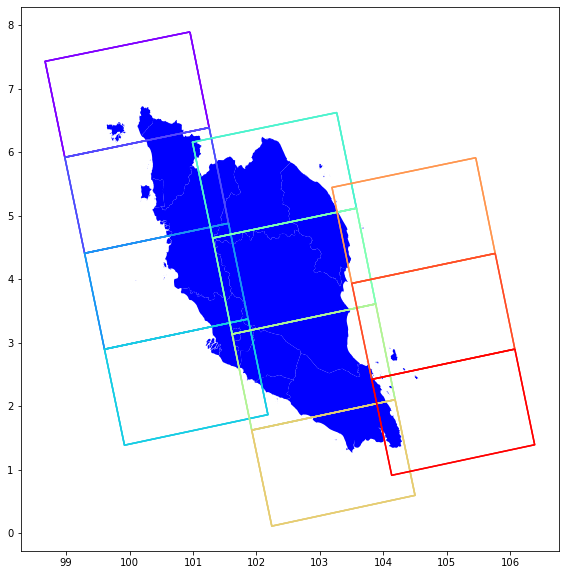

In [8]:
# Plot boundary
ax = gdf_boundary.plot(figsize=(10, 10), color='blue')
# Plot granules
frameNumbers = list(gdf_granules['frameNumber'].unique())
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(frameNumbers))))
for frameNumber in frameNumbers:
    c = next(color)
    gdf_granules[gdf_granules['frameNumber'] == frameNumber].boundary.plot(ax=ax, color=c)

### Submit HyP3 RTC jobs ###

For the initial processing of the Sentinel-1 granules, we make use of ASF's HyP3 API. Information about the specifics of this processing can be found in the [HyP3 documentation](https://hyp3-docs.asf.alaska.edu/). `s1_submit_hyp3_jobs.py` will submit the granules chosen in the previous step to the HyP3 API for processing. The processed granules will be saved in the following directory structure, as .zip files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
vegmapper.s1.submit_hyp3_jobs(proj_dir, s1_metadata)
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`csv/geojson`||CSV/geoJSON file that contains a list of granules to be submitted for processing. This was downloaded in the previous step.||Yes||None|

#### Notes ####

* Since ASF HyP3 stores the processed granules in their AWS S3 buckets, the data transfer will be much faster if you use an AWS S3 bucket for `proj_dir`.
* This script will require your Earthdata credentials, which can be obtained in [section 1](#1.-Get-credentials).


    


Submit HyP3 RTC jobs for the granules we selected, and upload the results to `proj_dir`:

In [24]:
vegmapper.s1.submit_hyp3_jobs(proj_dir, s1_metadata)


Enter Earthdata Username:  chenrh
Enter Earthdata Password:  ·············



Your remaining quota for HyP3 jobs: 966 granules.

You will be submitting the following granules for HyP3 RTC processing:
    2021_70_1187 - 3 granules
    2021_70_1192 - 3 granules
    2021_70_1197 - 3 granules
    2021_70_1202 - 3 granules
    2021_98_1185 - 2 granules
    2021_99_1190 - 2 granules
    2021_99_1195 - 2 granules
    2021_171_1183 - 3 granules
    2021_172_1188 - 3 granules
    2021_172_1193 - 3 granules
    2021_172_1198 - 3 granules


KeyboardInterrupt: Interrupted by user

### Sentinel-1 Processing ###

The final processing step involves calculating the temporal mean for the Sentinel-1 granules and removing left/right (cross-track) edge pixels where border noise is prominent. `s1_proc.py` handles this final processing step. Two helper scripts in the Sentinel directory are used: `s1_build_vrt.py` and `calc_vrt_stats.py` for the calculating the temporal mean, and `remove_edges.py` for removing edge pixels. The results will be stored in the following directory structure, as .tif and .vrt files:
```
        proj_dir
           └──sentinel_1
               └──<year>
                   └──<path_frame>
```

#### Usage ####

```
(vegmapper) % python s1_proc.py [-h] [--pf path_frame] [--m1 m1] [--m2 m2] proj_dir year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`path_frame`||If specified, only granules matching `path_frame` will be processed.||No||all path_frames under srcpath/year will be processed|
|`m1`||If specified, only granules with acquisition month >= `m1` will be included in VRT||No||None|
|`m2`||If specified, only granules with acquisition month <= `m2` will be included in VRT||No||None|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`year`||year of Sentinel-1 dataset||Yes||None|

#### Notes ####

* The processing will be slow if `proj_dir` is on AWS S3 or GCS because it requires heavy network I/O between the cloud and your local machine. If `proj_dir` is on AWS S3, it is strongly recommended that you run the processing on AWS EC2.

Perform the final processing step for our Sentinel-1 granules by running the cell below:

In [ ]:
vegmapper.s1.s1_proc(proj_dir, year, m1=1, m2=12, path_frame=None)

## Prepare ALOS-2 tiles ##

The next step of the data stack is ALOS-2 tiles. This involves downloading the ALOS-2 mosaic and processing them using an Enhanced Lee filter.

### Download ALOS/ALOS-2 Mosaic: `alos2_download_mosaic.py` ###

First, the ALOS-2 mosaic must be downloaded from the JAXA servers. This is accomplished via `alos2_download_mosaic.py`. The results will be stored in the following directory structure, as .tar.gz files:

```
        proj_dir
           └──alos2_mosaic
               └──<year>
                   └──tarfiles
```

#### Usage ####
```
(vegmapper) % alos2_download_mosaic.py [-h] proj_dir aoi year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`aoi`||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

#### Notes ####

* Downloading ALOS/ALOS-2 Mosaic data requires a JAXA account, which can be obtained in [section 1](#1.-Get-credentials).

Download ALOS/ALOS-2 Mosaic data for `aoi_boundary` and `year` and upload to `proj_dir`:

In [ ]:
vegmapper.alos2.download_tiles(proj_dir, aoi_boundary, year)

Filter the ALOS-2 Mosaic using Enhanced Lee filter:

### ALOS-2 Processing: `alos2_proc.py` ###
Next, the ALOS-2 mosaic is processed using an Enhanced Lee filter via `alos2_proc.py`. This will produce three .tif images for each tile: HV, HH, and INC, referring to the different polarizations of the ALOS-2 sensing instrument. Results will be stored in the following directory structure, as .tif files:
```
        proj_dir
           └──alos2_mosaic
               └──<year>
```

#### Usage ####

```
(vegmapper) % alos2_proc.py [-h] proj_dir year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|`proj_dir`||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|`year`||The year you wish to download the mosaic for (currently available for 2007-2010 and 2015-2019. This should be the same as the year used in the [sentinel-1 processing step](#Sentinel-1-Processing:-s1_proc.py).||Yes||None|

In [ ]:
vegmapper.alos2.proc_tiles(proj_dir, year, filter_win_size=5, filter_num_looks=1)

## Prepare Landsat NDVI ##

The next step of the data stack is Landsat-8 tiles. This involves downloading the Landsat data, masking clouds, extracting the median, and computing the NDVI (Normalized Difference Vegetation Index). These processing steps are handled using Google Earth Engine. The results will be exported to your Google Drive, and will have to be manually copied to your `proj_dir`. Once completed, they will be stored in the following location:
```
        proj_dir
           └──landsat_ndvi
               └──<year>
```
#### Usage ####

```
(vegmapper) % gee_export_landsat_ndvi.py [-h] sitename tiles res year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|res||The resolution of the Landsat-8 tiles. L8 tiles are natively at 30x30m resolution. Any resampling will use bilinear interpolation.||Yes||None|
|year||The year to download the L8 dataset for (was set previously in this notebook).||Yes||None|


Export the Landsat-8 tiles to Google Storage bucket:

In [21]:
vegmapper.gee.export_landsat_ndvi(aoi_name, aoi_tiles, res, year)


Submitting GEE jobs for exporting Landsat NDVI ...
#1: h0v0 started
#2: h0v1 started
#3: h0v2 started
#4: h0v3 skipped
#5: h0v4 skipped
#6: h1v0 started
#7: h1v1 started
#8: h1v2 started
#9: h1v3 started
#10: h1v4 skipped
#11: h2v0 started
#12: h2v1 started
#13: h2v2 started
#14: h2v3 started
#15: h2v4 started
#16: h3v0 skipped
#17: h3v1 started
#18: h3v2 started
#19: h3v3 started
#20: h3v4 started


## Prepare MODIS Tree Cover ##
The next step is MODIS Tree Cover Tiles. This involves downloading the MODIS dataset and extracting the Percent Tree Cover. The results will be exported to your Google Drive, and will have to be manually copied to your `proj_dir`. Once completed, they will be stored in the following location:
```
        proj_dir
           └──modis_tree_cover
               └──<year>
```
#### Usage ####

```
(vegmapper) % gee_export_modis_tc.py [-h] sitename tiles res year
```

|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|res||The resolution of the MODIS TC tiles. MODIS TC tiles are natively at 250x250m resolution. Any resampling will use bilinear interpolation.||Yes||None|
|year||The year to download the MODIS TC dataset for (was set previously in this notebook).||Yes||None|

Export the MODIS-TC tiles to Google Storage bucket:

In [6]:
vegmapper.gee.export_modis_tc(aoi_name, aoi_tiles, res, year)


Submitting GEE jobs for exporting MODIS tree cover ...
#1: h0v0 started
#2: h0v1 started
#3: h0v2 started
#4: h0v3 skipped
#5: h0v4 skipped
#6: h1v0 started
#7: h1v1 started
#8: h1v2 started
#9: h1v3 started
#10: h1v4 skipped
#11: h2v0 started
#12: h2v1 started
#13: h2v2 started
#14: h2v3 started
#15: h2v4 started
#16: h3v0 skipped
#17: h3v1 started
#18: h3v2 started
#19: h3v3 started
#20: h3v4 started


## Build Stacks: `build_stacks.py` ##
The final step in the workflow is stacking all of the data into 8-band geotiffs using `build_stacks.py`. The bands are as follows, in order: C-VV / C-VH / C-INC / L-HH / L-HV / L-INC / NDVI / TC, where C-bands come from the Sentinel-1 dataset, and L-bands come from the ALOS-2 dataset. Completed stacks can be found in the following directory structure, as .tif files:
```
        proj_dir
           └──stacks
               └──<year>
                   └──all-bands
```
#### Usage ####

```
(vemapper) % build_stacks.py [-h] [--sitename sitename] proj_dir tiles year
```
|Arguments||Description||Required||Default|
|----||----||----||----|
|sitename||The name of the site. This is used in naming the final product.||No||Base directory of `proj_dir` will be used|
|proj_dir||Your project directory (see [section 3](#3.-Set-up-project-directory)).||Yes||None|
|tiles||The geoJSON file containing the tiles generated for your area of interest (see [section 4](#4.-Prepare-UTM-tiles-for-Area-of-Interest-(AOI):-prep_tiles.py)).||Yes||None|
|year||The year to produce the stacks for (was set previously in this notebook).||Yes||None|

Build the 8-band stacks for the specified year and area of interest:

In [ ]:
# Set arguments
sitename = ''
sitename, proj_dir, aoi, year

In [ ]:
# Format optional arguments
sitename = format_arg(sitename, '--sitename')

In [ ]:
python build_stacks.py {sitename} {proj_dir} {aoi} {year}

Show results in `proj_dir`:

In [ ]:
!aws s3 ls {proj_dir}stacks/{year}/all-bands/

Build a virtual raster containing all stack tiles to be used for analysis: